In [1]:
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout, concatenate

In [2]:
def load_images_from_kaggle(folder, target_shape=(224, 224), label = 0):
    images = []
    labels = []
    filepaths = [os.path.join(folder, filename) for filename in os.listdir(folder) if filename.endswith('.jpg') or filename.endswith('.png')]
    for filepath in filepaths:
        img = cv2.imread(filepath)
        if img is not None:
            # Resize the image to match the target shape
            img = cv2.resize(img, target_shape)
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)



In [3]:
def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4): 
    # 1st path:
    path1 = Conv2D(filters=f1, kernel_size=(1, 1), padding='same', activation='relu')(input_layer)

    # 2nd path
    path2 = Conv2D(filters=f2_conv1, kernel_size=(1, 1), padding='same', activation='relu')(input_layer)
    path2 = Conv2D(filters=f2_conv3, kernel_size=(3, 3), padding='same', activation='relu')(path2)

    # 3rd path
    path3 = Conv2D(filters=f3_conv1, kernel_size=(1, 1), padding='same', activation='relu')(input_layer)
    path3 = Conv2D(filters=f3_conv5, kernel_size=(5, 5), padding='same', activation='relu')(path3)

    # 4th path
    path4 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input_layer)
    path4 = Conv2D(filters=f4, kernel_size=(1, 1), padding='same', activation='relu')(path4)

    output_layer = concatenate([path1, path2, path3, path4], axis=-1)

    return output_layer

In [4]:
def GoogLeNet():
    # input layer 
    input_layer = Input(shape=(224, 224, 3))

    # convolutional layer: filters = 64, kernel_size = (7,7), strides = 2
    X = Conv2D(filters=64, kernel_size=(7, 7), strides=2, padding='valid', activation='relu')(input_layer)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size=(3, 3), strides=2)(X)

    # convolutional layer: filters = 64, strides = 1
    X = Conv2D(filters=64, kernel_size=(1, 1), strides=1, padding='same', activation='relu')(X)

    # convolutional layer: filters = 192, kernel_size = (3,3)
    X = Conv2D(filters=192, kernel_size=(3, 3), padding='same', activation='relu')(X)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size=(3, 3), strides=2)(X)

    # 1st Inception block
    X = Inception_block(X, f1=64, f2_conv1=96, f2_conv3=128, f3_conv1=16, f3_conv5=32, f4=32)

    # 2nd Inception block
    X = Inception_block(X, f1=128, f2_conv1=128, f2_conv3=192, f3_conv1=32, f3_conv5=96, f4=64)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size=(3, 3), strides=2)(X)

    # 3rd Inception block
    X = Inception_block(X, f1=192, f2_conv1=96, f2_conv3=208, f3_conv1=16, f3_conv5=48, f4=64)

    # Extra network 1:
    X1 = AveragePooling2D(pool_size=(5, 5), strides=3)(X)
    X1 = Conv2D(filters=128, kernel_size=(1, 1), padding='same', activation='relu')(X1)
    X1 = Flatten()(X1)
    X1 = Dense(1024, activation='relu')(X1)
    X1 = Dropout(0.7)(X1)
    X1 = Dense(2, activation='softmax')(X1)  # Modify here for binary classification

    # 4th Inception block
    X = Inception_block(X, f1=160, f2_conv1=112, f2_conv3=224, f3_conv1=24, f3_conv5=64, f4=64)

    # 5th Inception block
    X = Inception_block(X, f1=128, f2_conv1=128, f2_conv3=256, f3_conv1=24, f3_conv5=64, f4=64)

    # 6th Inception block
    X = Inception_block(X, f1=112, f2_conv1=144, f2_conv3=288, f3_conv1=32, f3_conv5=64, f4=64)

    # Extra network 2:
    X2 = AveragePooling2D(pool_size=(5, 5), strides=3)(X)
    X2 = Conv2D(filters=128, kernel_size=(1, 1), padding='same', activation='relu')(X2)
    X2 = Flatten()(X2)
    X2 = Dense(1024, activation='relu')(X2)
    X2 = Dropout(0.7)(X2)
    X2 = Dense(2, activation='softmax')(X2)  # Modify here for binary classification

    # 7th Inception block
    X = Inception_block(X, f1=256, f2_conv1=160, f2_conv3=320, f3_conv1=32,
                        f3_conv5=128, f4=128)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size=(3, 3), strides=2)(X)

    # 8th Inception block
    X = Inception_block(X, f1=256, f2_conv1=160, f2_conv3=320, f3_conv1=32, f3_conv5=128, f4=128)

    # 9th Inception block
    X = Inception_block(X, f1=384, f2_conv1=192, f2_conv3=384, f3_conv1=48, f3_conv5=128, f4=128)

    # Global Average pooling layer
    X = GlobalAveragePooling2D(name='GAPL')(X)

    # Dropoutlayer
    X = Dropout(0.4)(X)

    # output layer
    X = Dense(2, activation='softmax')(X)  # Modify here for binary classification

    # model
    model = Model(input_layer, [X, X1, X2], name='GoogLeNet')

    return model


In [6]:
non_smoke_img, non_smoke_lab = load_images_from_kaggle('./input/data/not_smoking/', label=0)
smoke_img, smoke_lab = load_images_from_kaggle('./input/data/smoking/', label=1)

In [7]:
X = np.concatenate((non_smoke_img, smoke_img), axis=0)
y = np.concatenate((non_smoke_lab, smoke_lab), axis=0)

In [8]:
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

In [9]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Normalize pixel values
X_train = X_train / 255.0
X_test = X_test / 255.0

In [11]:
# Define the model
model = GoogLeNet()


In [12]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=[['accuracy'], ['accuracy'], ['accuracy']])


In [13]:
# Train the model
history = model.fit(X_train, [y_train, y_train, y_train],
                    validation_data=(X_test, [y_test, y_test, y_test]),
                    epochs=30, batch_size=32)

Epoch 1/30
73/73 [==============================] - 220s 3s/step - loss: 1.9598 - dense_4_loss: 0.6590 - dense_1_loss: 0.6449 - dense_3_loss: 0.6558 - dense_4_accuracy: 0.6496 - dense_1_accuracy: 0.6565 - dense_3_accuracy: 0.6479 - val_loss: 1.8703 - val_dense_4_loss: 0.6347 - val_dense_1_loss: 0.6342 - val_dense_3_loss: 0.6013 - val_dense_4_accuracy: 0.6346 - val_dense_1_accuracy: 0.6569 - val_dense_3_accuracy: 0.6346
Epoch 2/30
73/73 [==============================] - 225s 3s/step - loss: 1.7469 - dense_4_loss: 0.5894 - dense_1_loss: 0.5763 - dense_3_loss: 0.5813 - dense_4_accuracy: 0.6754 - dense_1_accuracy: 0.7080 - dense_3_accuracy: 0.6883 - val_loss: 1.6774 - val_dense_4_loss: 0.5729 - val_dense_1_loss: 0.5451 - val_dense_3_loss: 0.5594 - val_dense_4_accuracy: 0.7273 - val_dense_1_accuracy: 0.7358 - val_dense_3_accuracy: 0.7170
Epoch 3/30
73/73 [==============================] - 222s 3s/step - loss: 1.6302 - dense_4_loss: 0.5487 - dense_1_loss: 0.5373 - dense_3_loss: 0.5441 - den

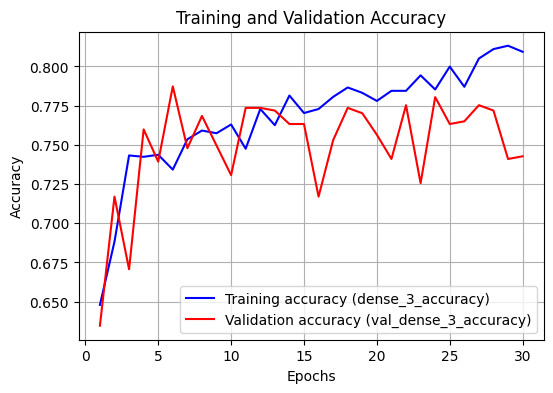

Final Training Accuracy: 0.8094
Final Validation Accuracy: 0.7427


In [30]:
import matplotlib.pyplot as plt

# Extracting accuracy values for dense_3 from the history object
dense_3_accuracy = history.history['dense_3_accuracy']
val_dense_3_accuracy = history.history['val_dense_3_accuracy']

# Number of epochs
epochs = range(1, len(dense_3_accuracy) + 1)

# Plotting training and validation accuracy
plt.figure(figsize=(6, 4))
plt.plot(epochs, dense_3_accuracy, 'b', label='Training accuracy (dense_3_accuracy)')
plt.plot(epochs, val_dense_3_accuracy, 'r', label='Validation accuracy (val_dense_3_accuracy)')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Printing final training and validation accuracy
print(f'Final Training Accuracy: {dense_3_accuracy[-1]:.4f}')
print(f'Final Validation Accuracy: {val_dense_3_accuracy[-1]:.4f}')
